In [1]:
import time
import torch.backends.cudnn as cudnn
from torch import nn
from torch.utils.data import DataLoader
from models import Generator, Discriminator, TruncatedVGG19
from datasets import SRDataset
from utils import *
from utils_.dataloader import Dataset as dataset
import utils_.helper_functions as helper_functions
import torch
from datetime import datetime
from models import SRResNet

In [2]:
# Data parameters
data_folder = './'  # folder with JSON data files
crop_size = 300  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 16  # number of residual blocks

# Learning parameters
checkpoint = "checkpoint_srresnet.pth.tar"  # path to model checkpoint, None if none
batch_size = 24  # batch size
start_epoch = 0  # start at this epoch
iterations = 1e6  # number of training iterations
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 500  # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
cudnn.benchmark = True


cuda


In [3]:
def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint

    # Initialize model or load checkpoint
    if checkpoint is None:
        model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                         n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
        # Initialize the optimizer
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                                     lr=lr)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = nn.MSELoss().to(device)

    # Custom dataloaders
    working_directory = "C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\"
    folder_path = "C:\\Users\\accou\\Documents\\thesis\\data\\"
    dataset_file = "C:\\Users\\accou\\Documents\\thesis\\images_subfolders3.pkl"
    transform = "histogram_matching"
    sen2_tile_train = "T30UXU"
    sen2_tile_val   = "T30UUU"
    sen2_tile_test  = "all"
    location = "local"
    dataset_train = dataset(folder_path,dataset_file,transform,sen2_amount=1, sen2_tile = sen2_tile_train, location=location)
    train_loader = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=1,pin_memory=True,drop_last=True)
    print("dataloader instanciated!")
    print("Len. Train: ",len(train_loader),"(Batch Sz. "+str(batch_size),")")

    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)

    # Epochs
    for epoch in range(start_epoch, epochs):
        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet.pth.tar')



In [4]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: content loss function (Mean Squared-Error loss)
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables batch normalization

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), in [-1, 1]

        # Forward prop.
        sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]

        # Loss
        loss = criterion(sr_imgs, hr_imgs)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        # Keep track of loss
        losses.update(loss.item(), lr_imgs.size(0))

        # Keep track of batch time
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % print_freq == 0:
            helper_functions.plot_tensors_window(hr_imgs,lr_imgs,sr_imgs,0,0,fig_path="C:\\Users\\accou\\Documents\\GitHub\\a-PyTorch-Tutorial-to-Super-Resolution\\images_srresnet\\")
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader),
                                                                    batch_time=batch_time,
                                                                    data_time=data_time, loss=losses))
    del lr_imgs, hr_imgs, sr_imgs  # free some memory since their histories may be stored

dataloader instanciated!
Len. Train:  574 (Batch Sz. 16 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: [9][0/574]----Batch Time 8.628 (8.628)----Data Time 3.382 (3.382)----Loss 0.0006 (0.0006)


KeyboardInterrupt: 

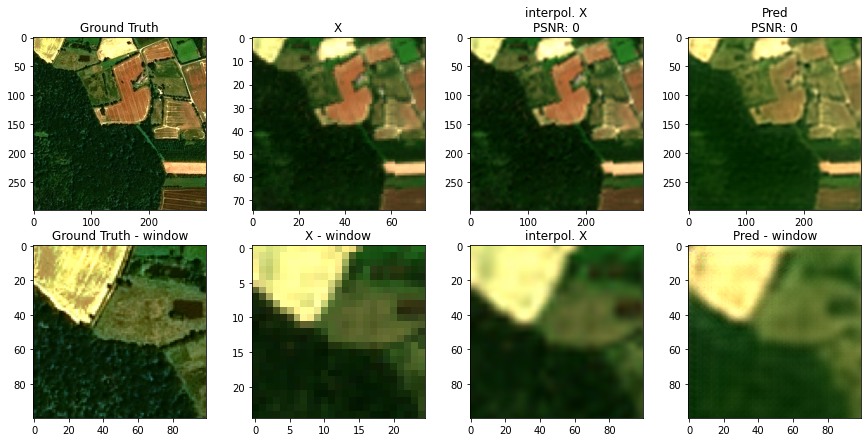

In [5]:
if __name__ == "__main__":
    main()